we have numerically approximated the high-passed LIM auto spectrum which should be positive semi-definite (it is a covariance) but minor numerical artifacts cause a few eigenvalues to be negative. 

[ChengHigham98](https://doi.org/10.1137/S0895479896302898) Theorem 3.1:
Let the symmetric matrix $A\in\mathbb{R}^{n \times n}$ have the spectral decomposition $A = Q \mskip1mu\mathrm{diag}(\lambda_i) \mskip1muQ^T$ and let $\delta \ge 0$. The unique matrix with smallest eigenvalue at least $\delta$ nearest to $A$ in the Frobenius norm is given by
$$ \notag X = Q \mskip1mu \mathrm{diag}(\tau_i) \mskip1mu Q^T, \quad \tau_i = \begin{cases} \lambda_i, & \lambda_i \geq \delta\\ \delta, & \lambda_i < \delta. \end{cases} $$
So if we let $\delta=0$, $X$ is the positive semi-definite matrix closest to $A$ (under the Frobenius norm). I think $X$ is the thing to use instead of $A$ for our ${\sf SNR}$ calculations. 

This notebook checks that this isn't unreasonable

In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid
from tqdm import tqdm, trange
from LIMxCMBL.experiments import *

In [2]:
experiment = 'CCAT-prime'

In [3]:
zmin = experiments[experiment]['zmin']
zmax = experiments[experiment]['zmax']
line_str = experiments[experiment]['line_str']

Omega_field  =  experiments[experiment]['Omega_field']
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [4]:
n_bins = 100
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [5]:
import matplotlib.pyplot as plt

In [6]:
from tqdm import trange

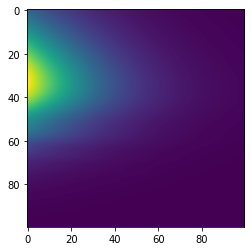

In [7]:
I_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_'
I_kappa_fname +='zmin_%.5f_zmax_%.5f_quad_next_%d.npy'%(zmin, 
                                                        zmax, 
                                                        1000)

I_kappa_unbinned = np.load(I_kappa_fname)

I_kappa = np.zeros((len(ells), n_bins))
external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), 1000)
for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            I_kappa[:,i] = (np.sum(I_kappa_unbinned[:,idx1[0]:idx1[-1]+1,], 
                                 axis=(1)) / len(idx1))
            
plt.imshow(I_kappa)

100%|██████████| 100/100 [00:02<00:00, 34.95it/s]


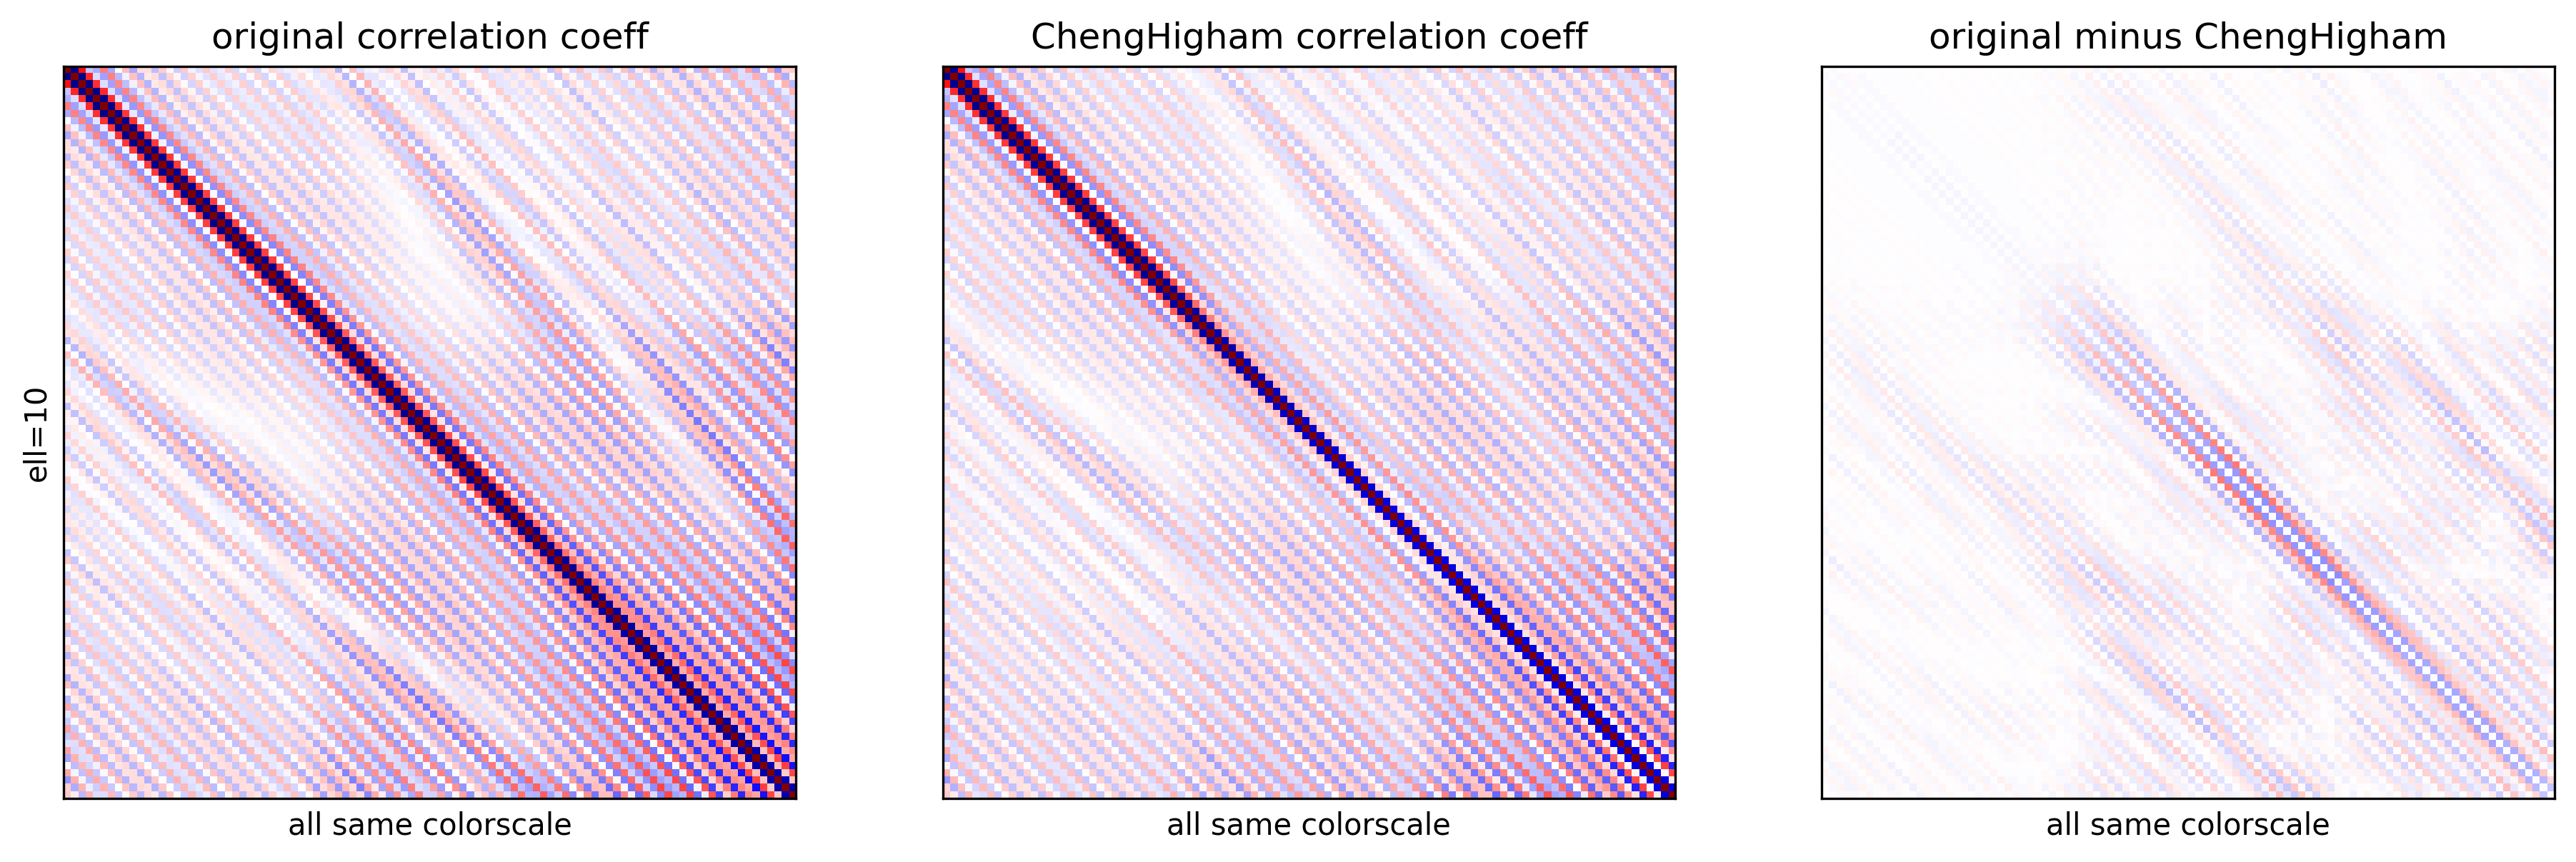

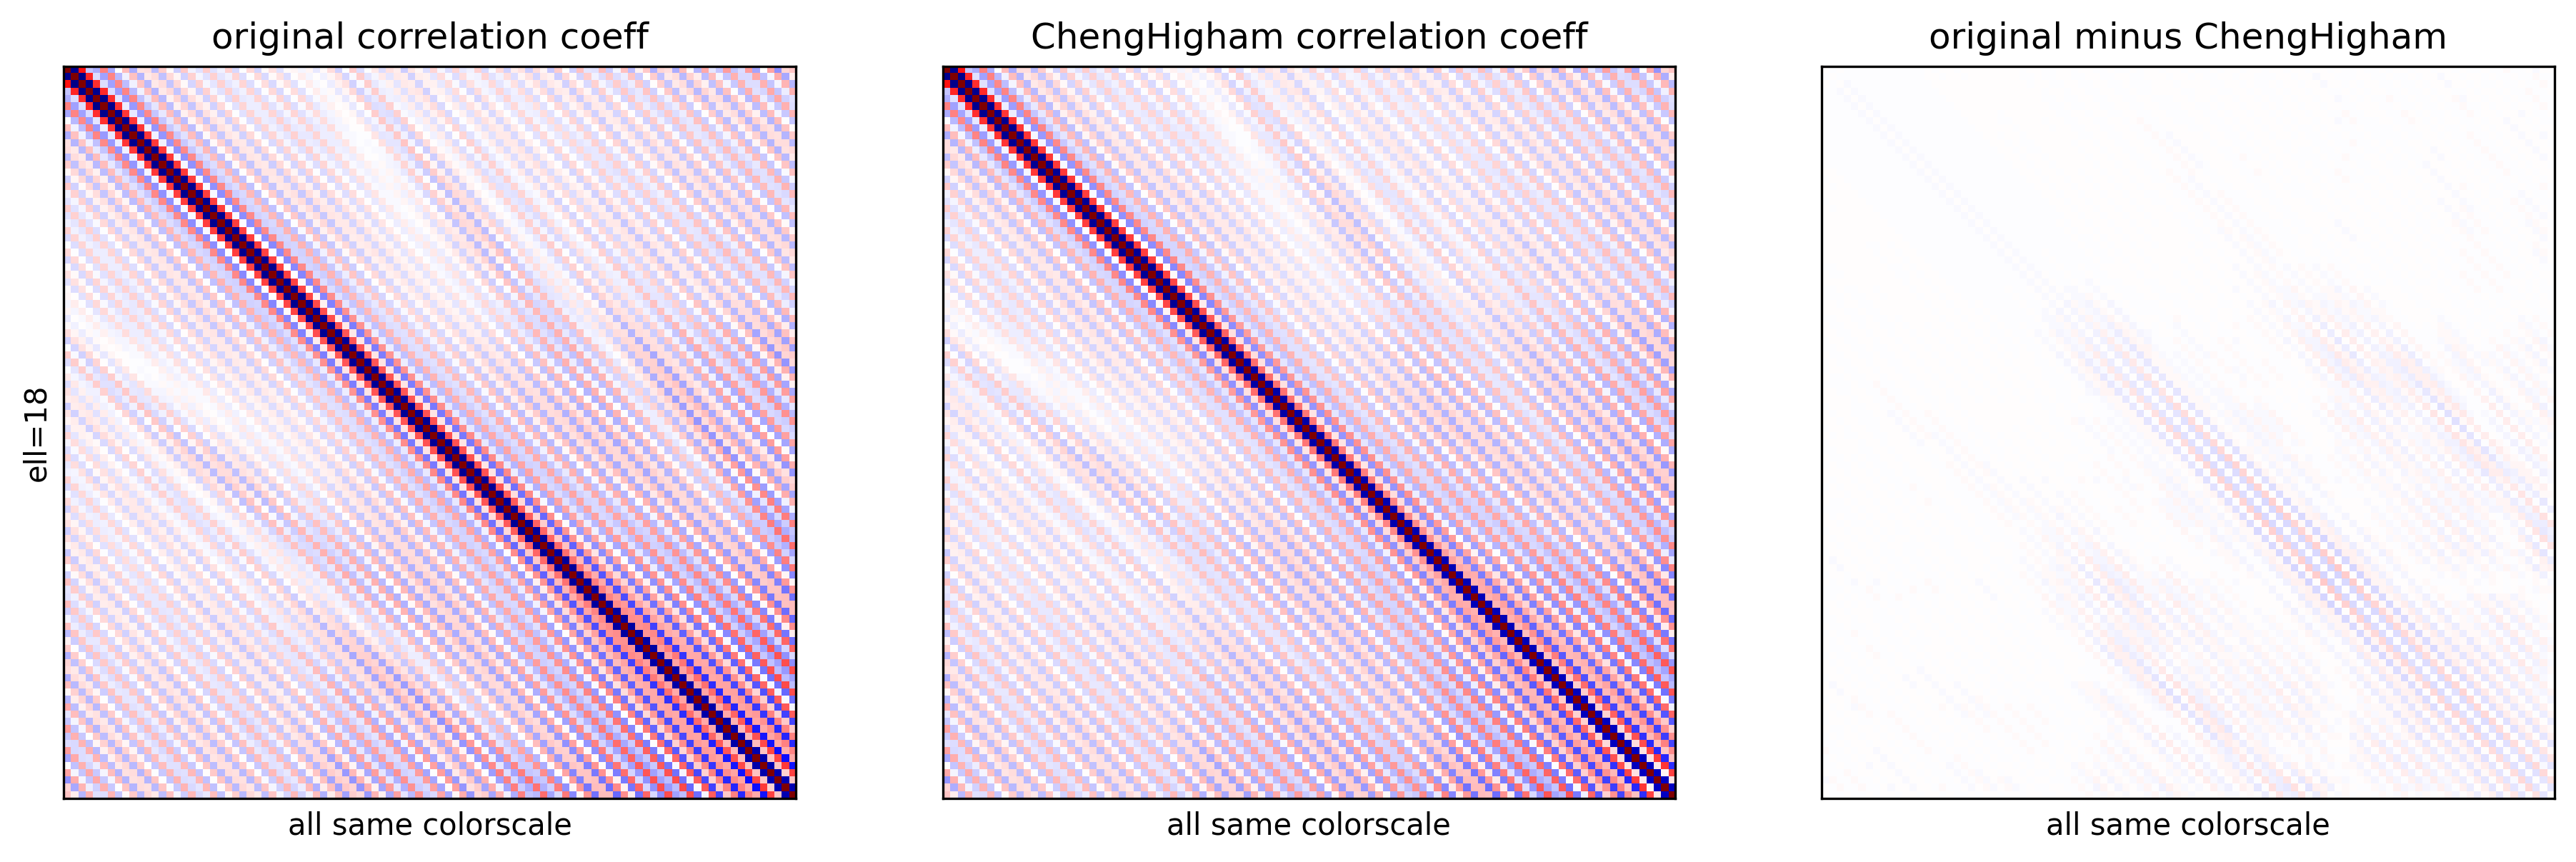

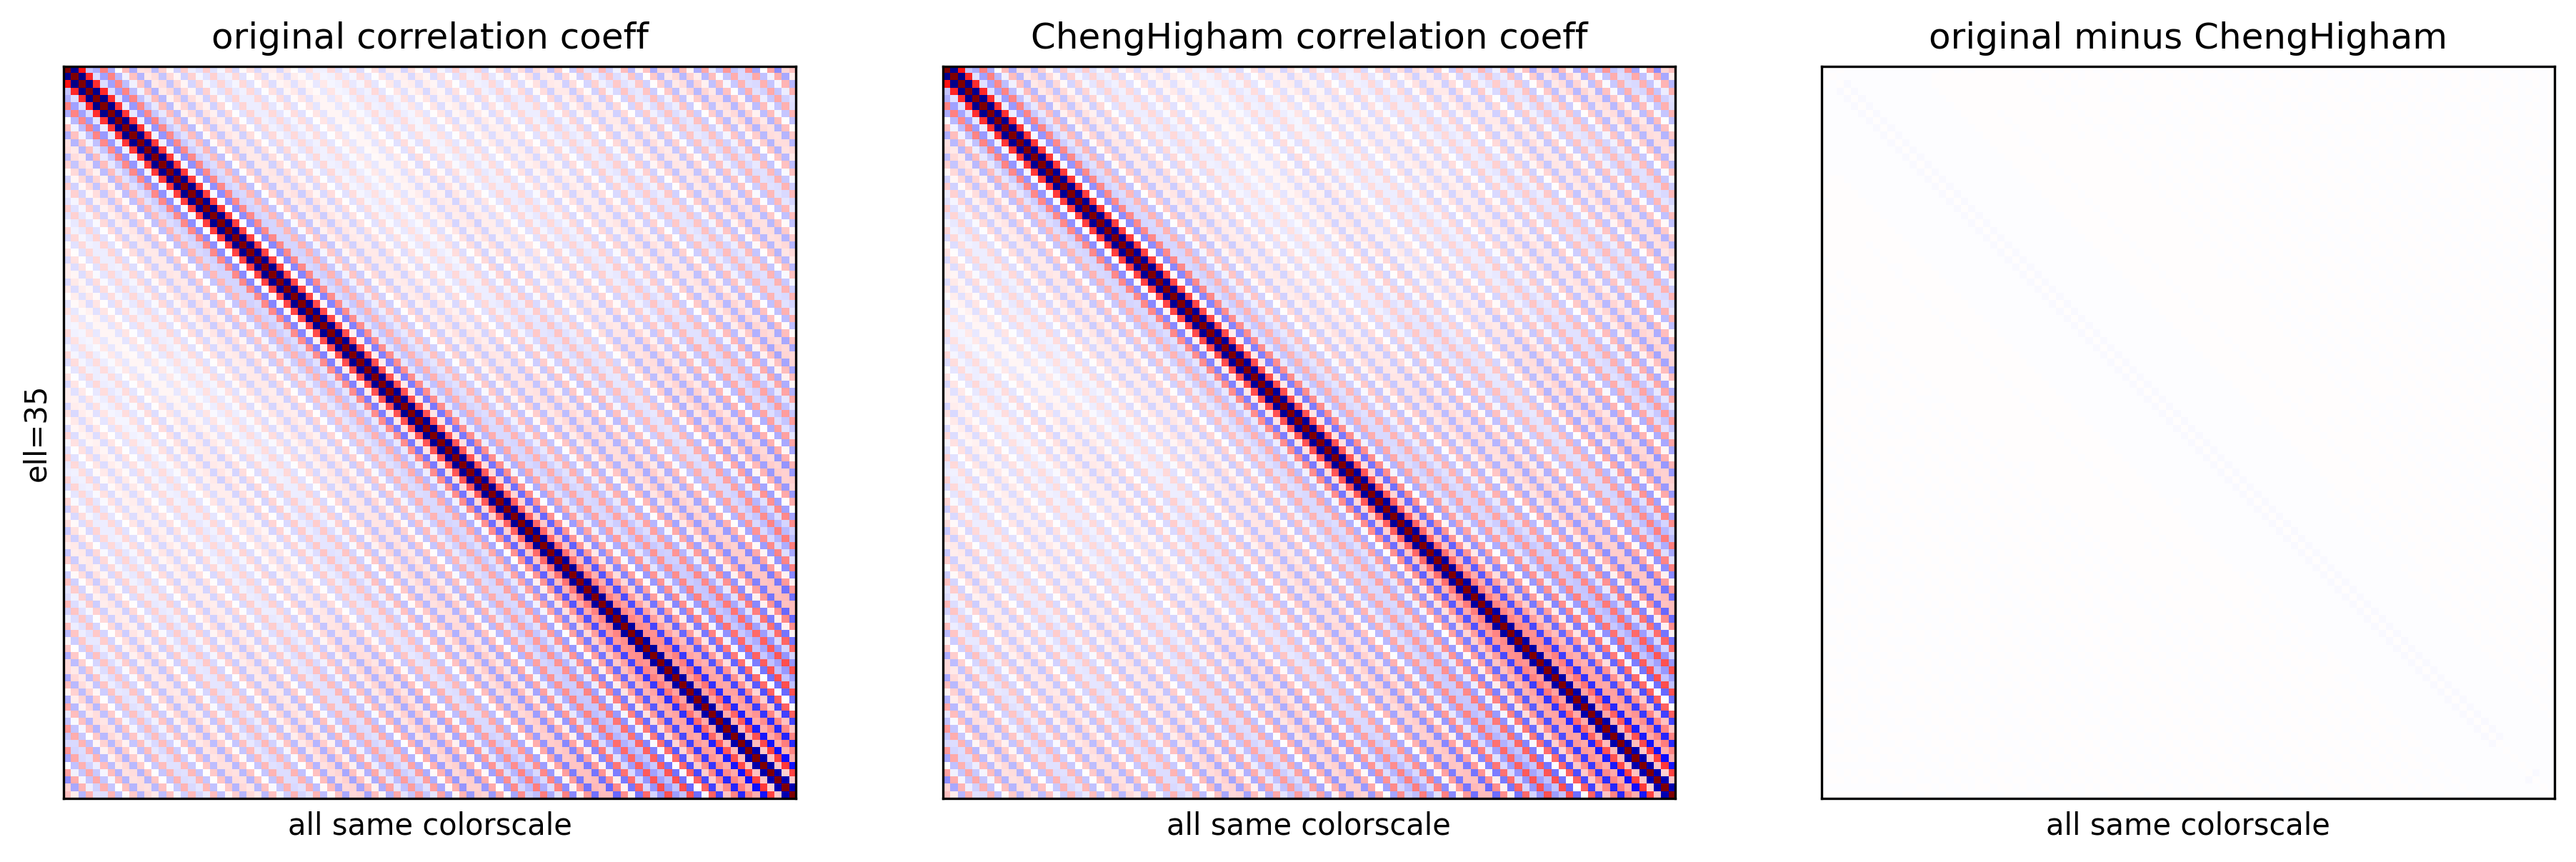

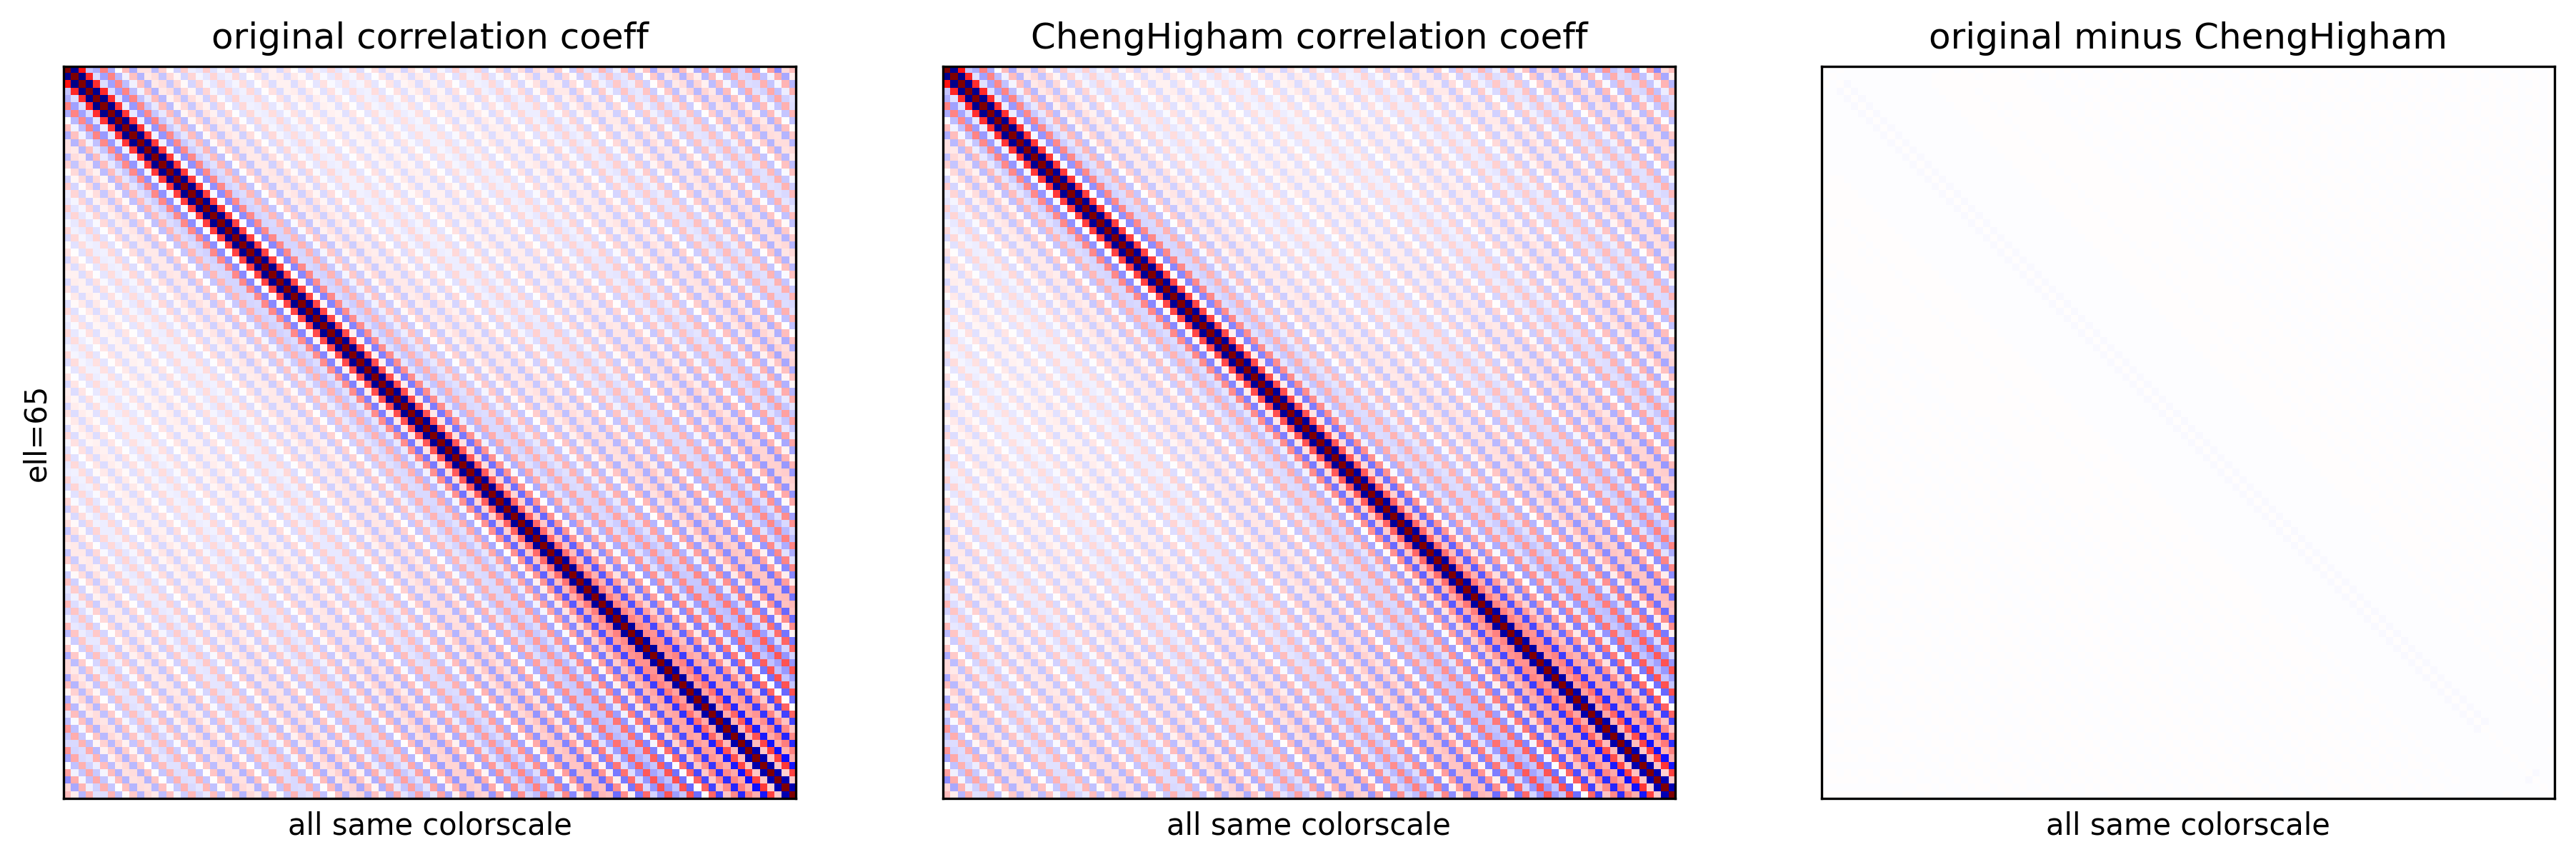

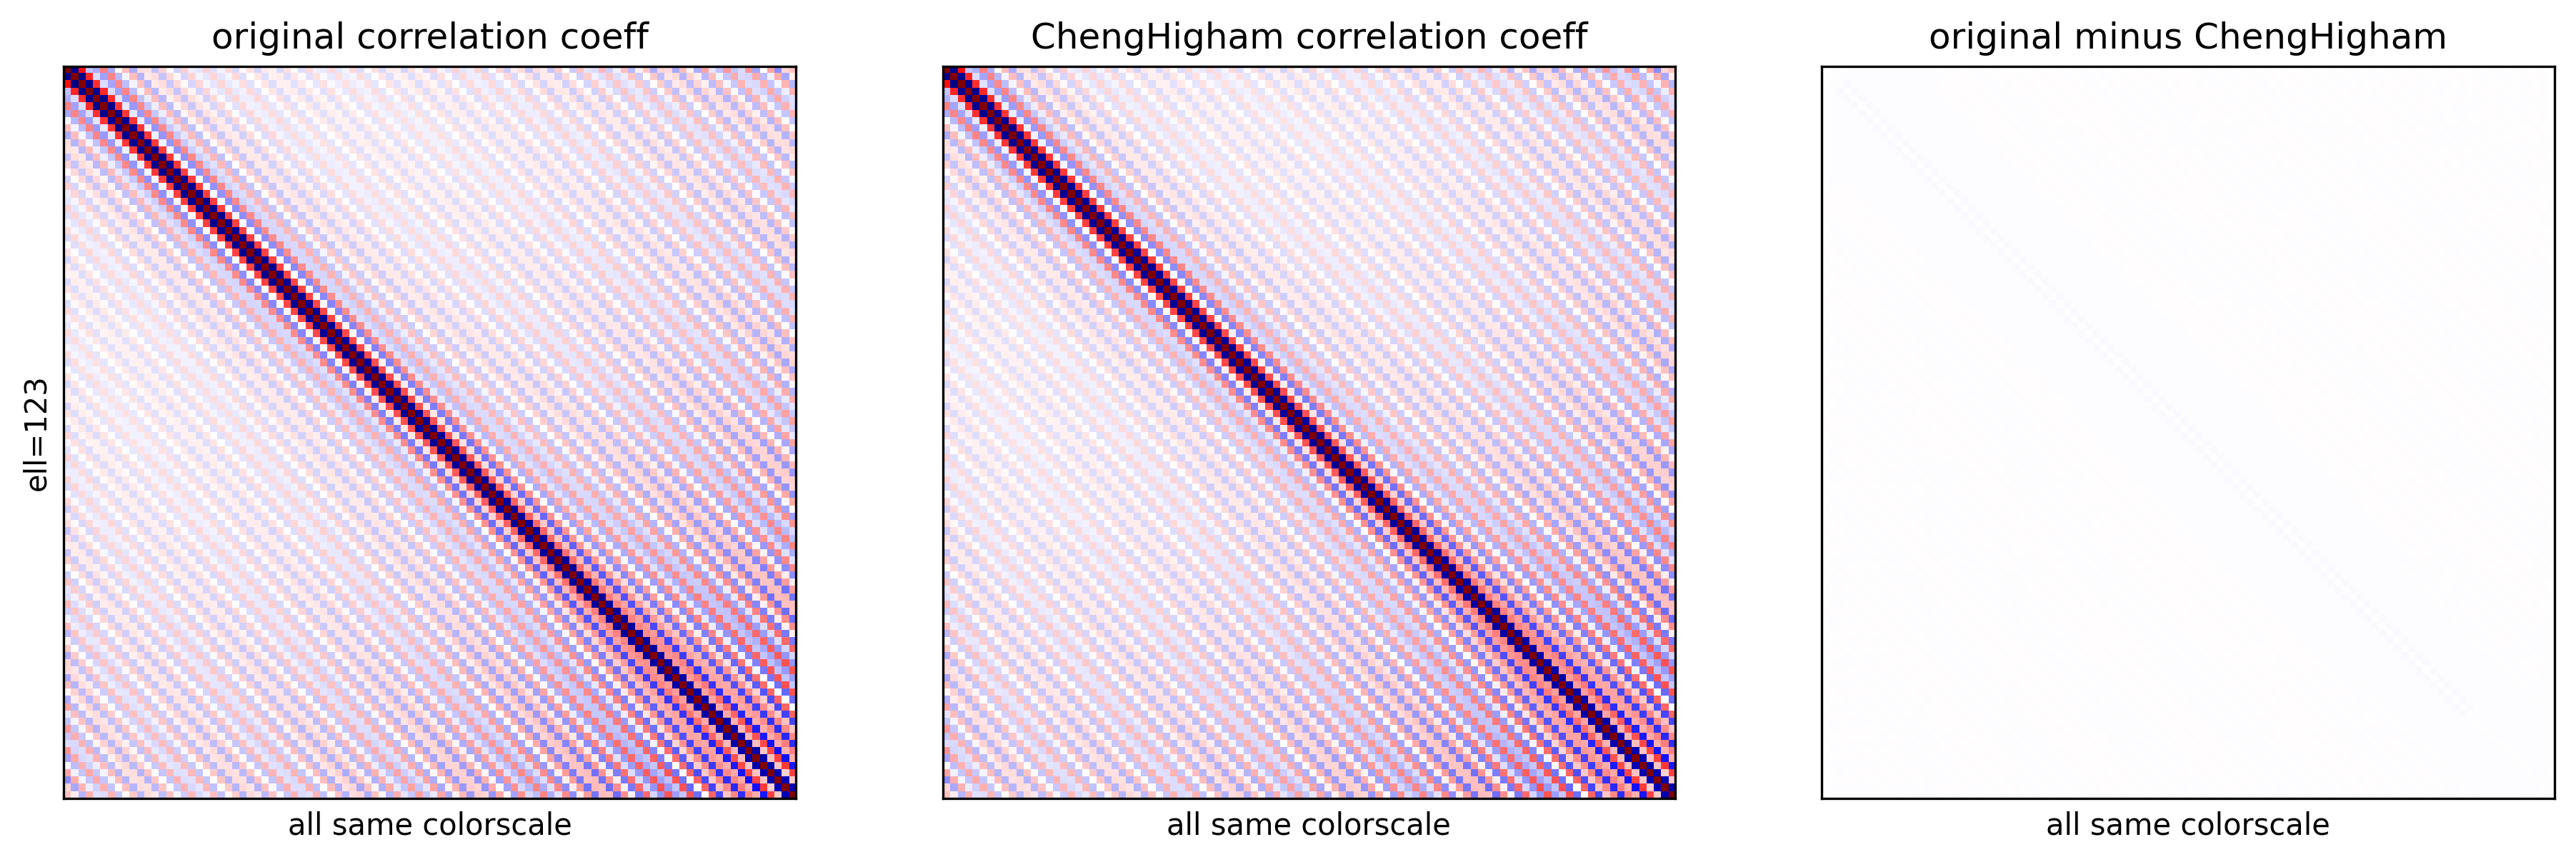

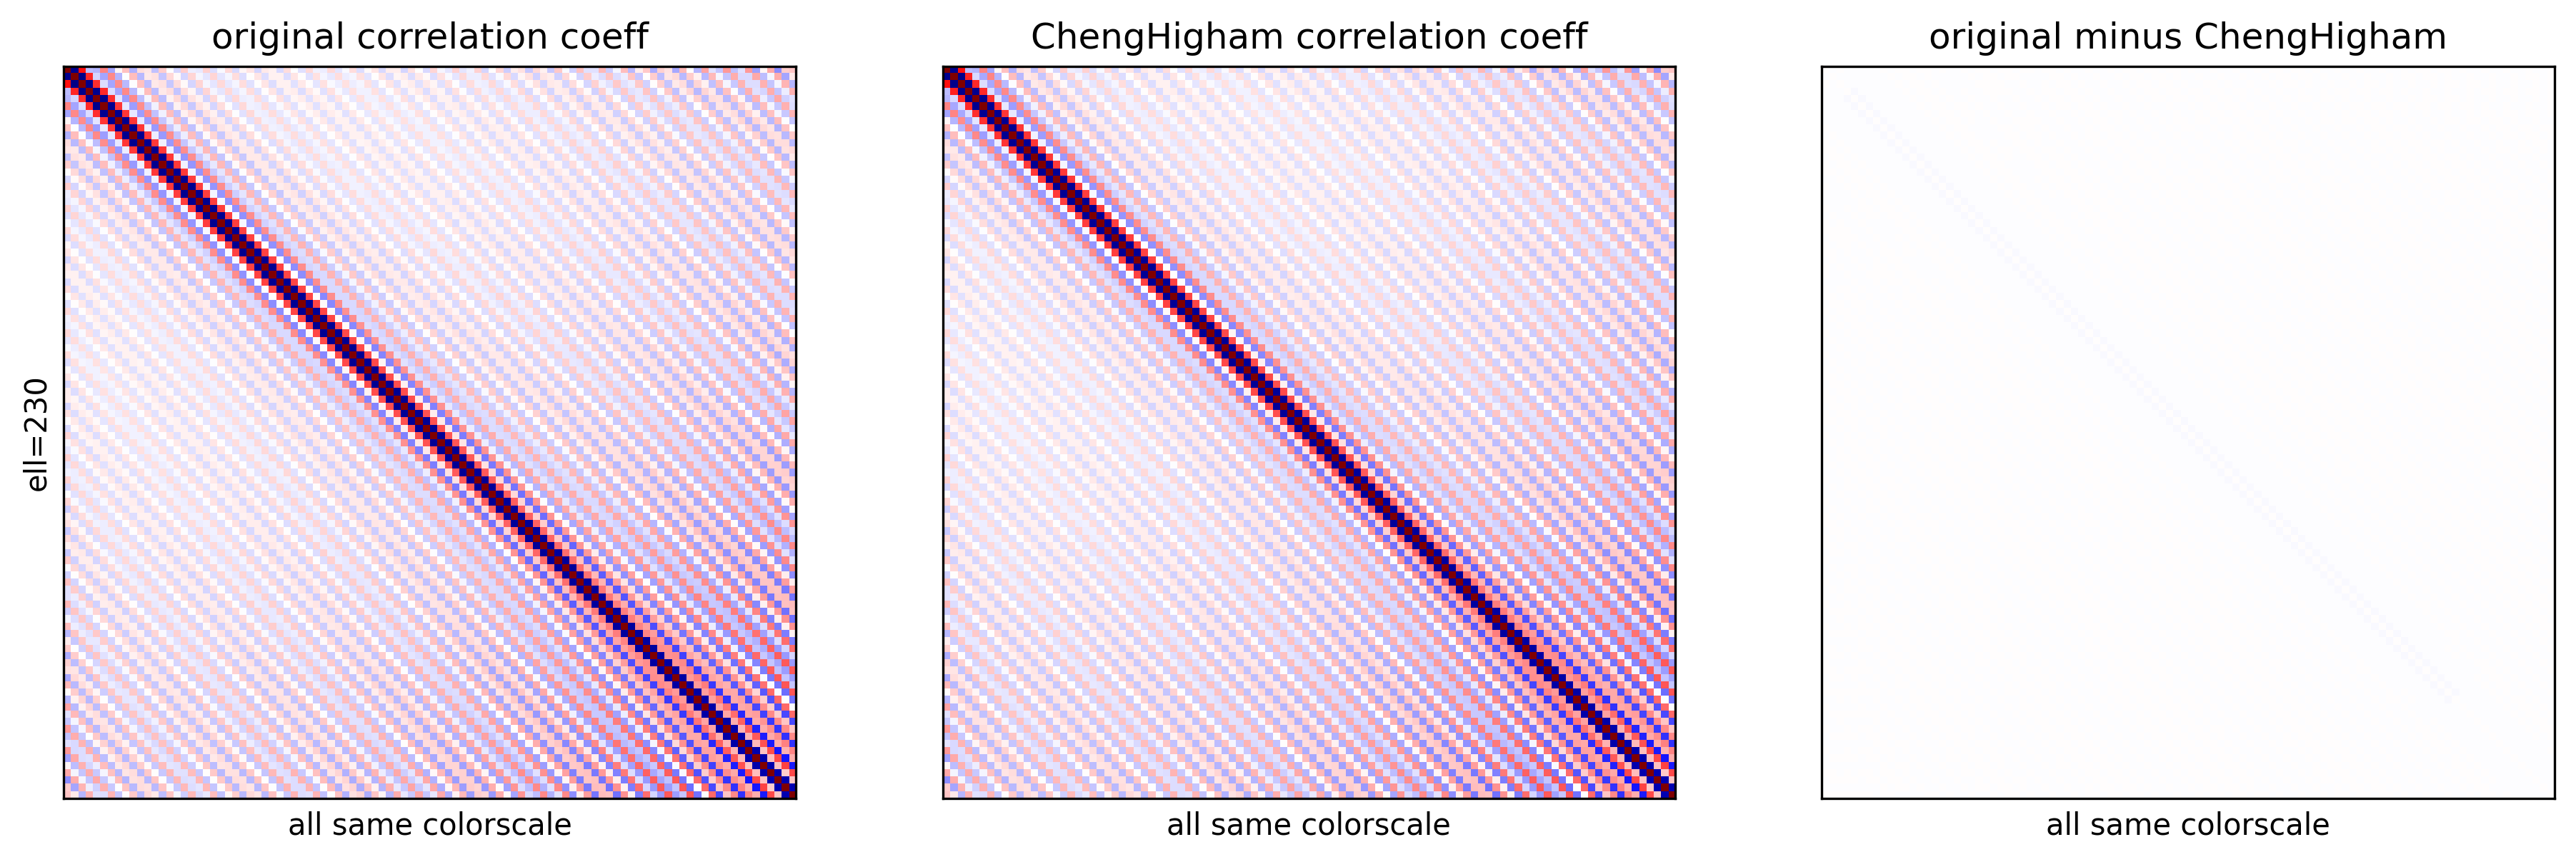

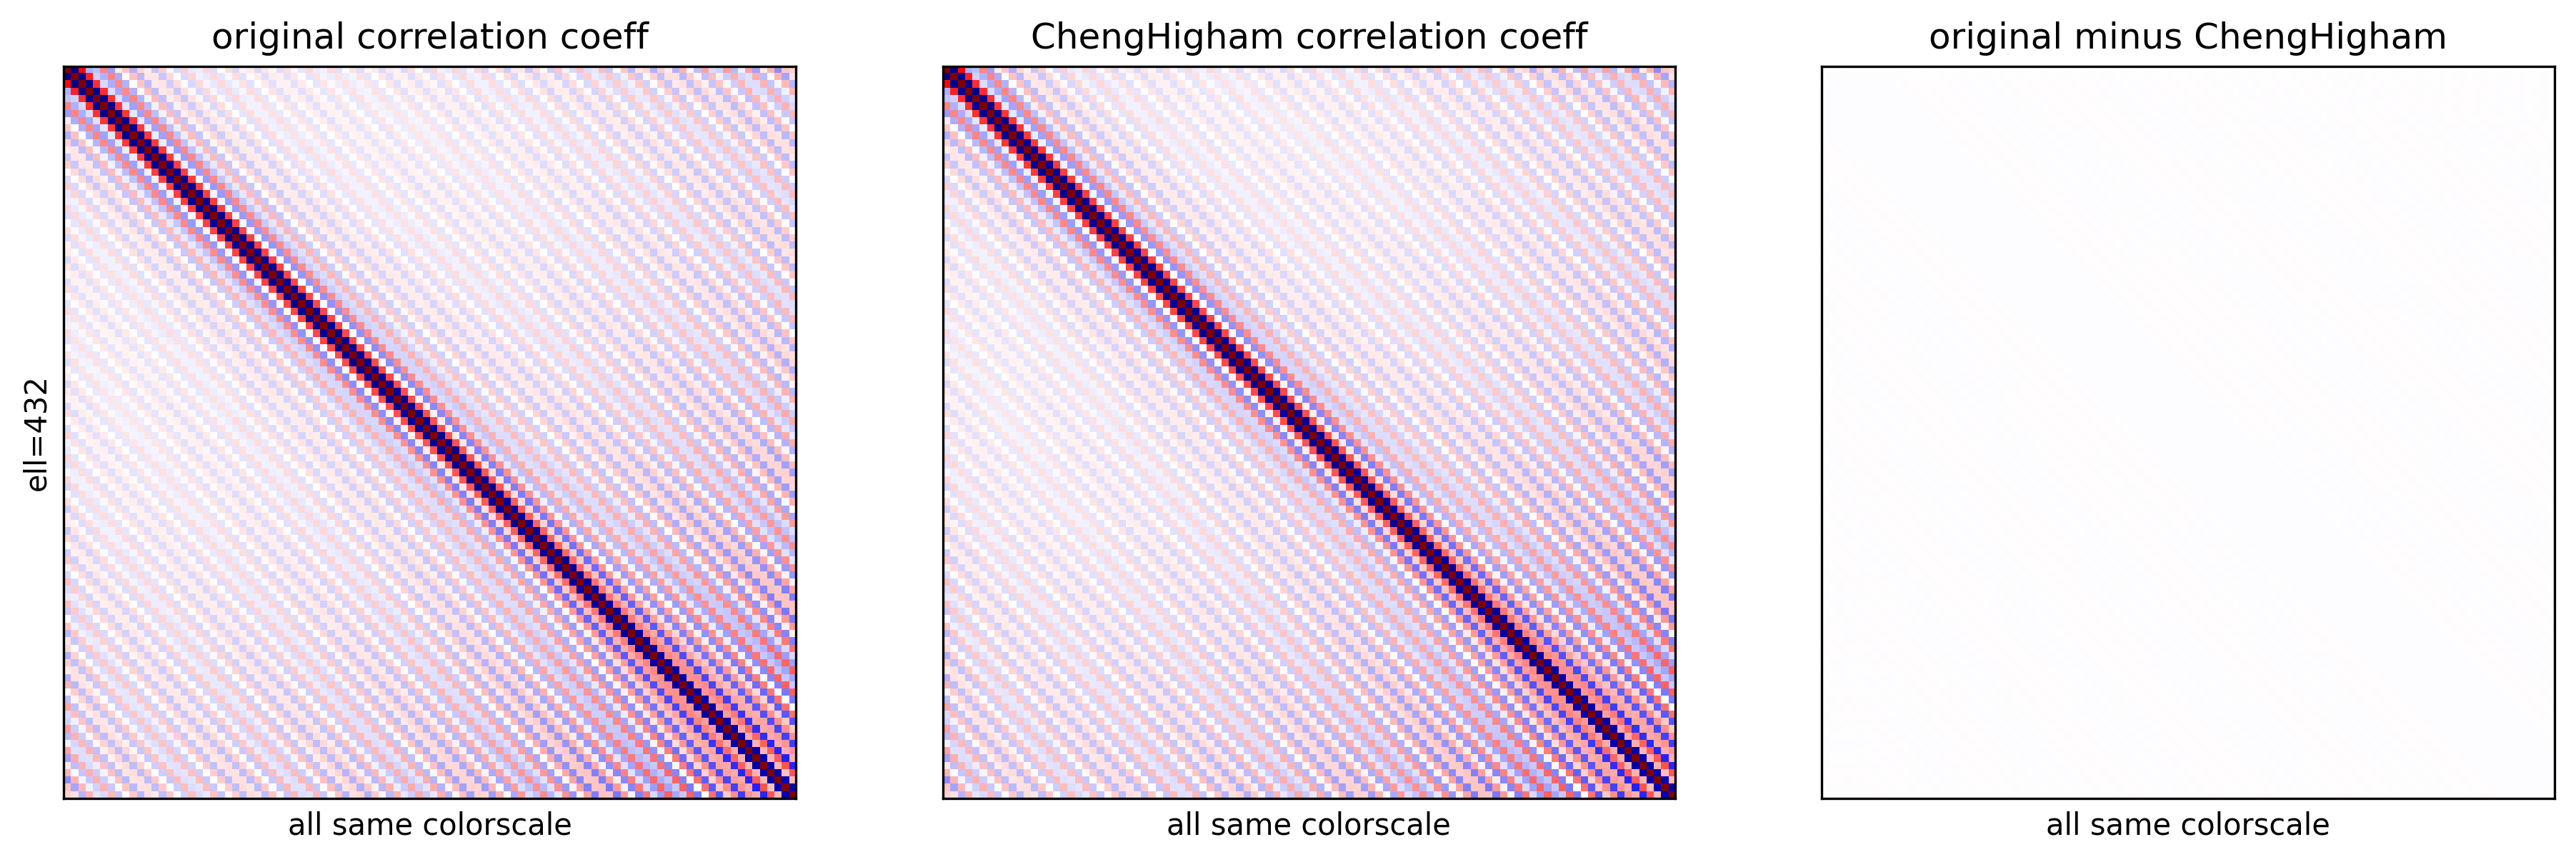

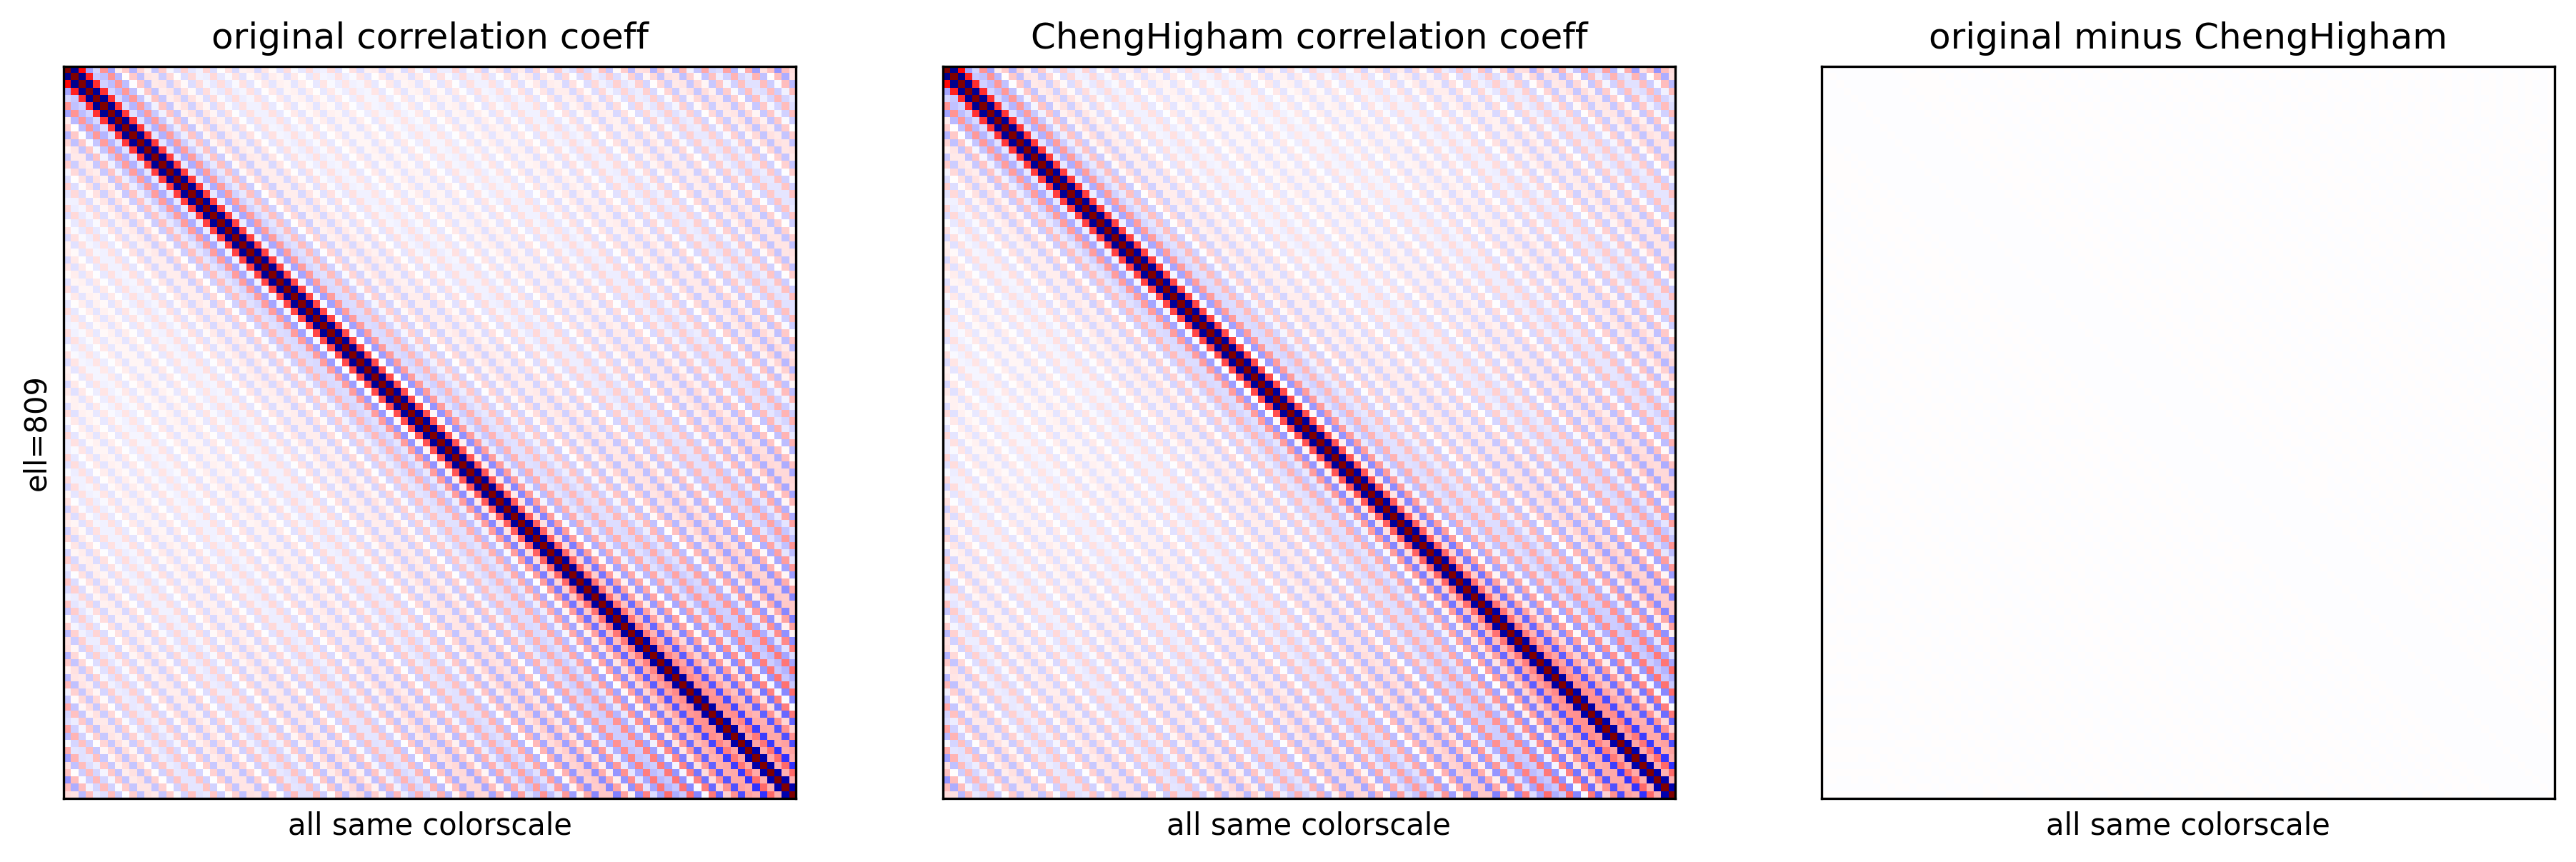

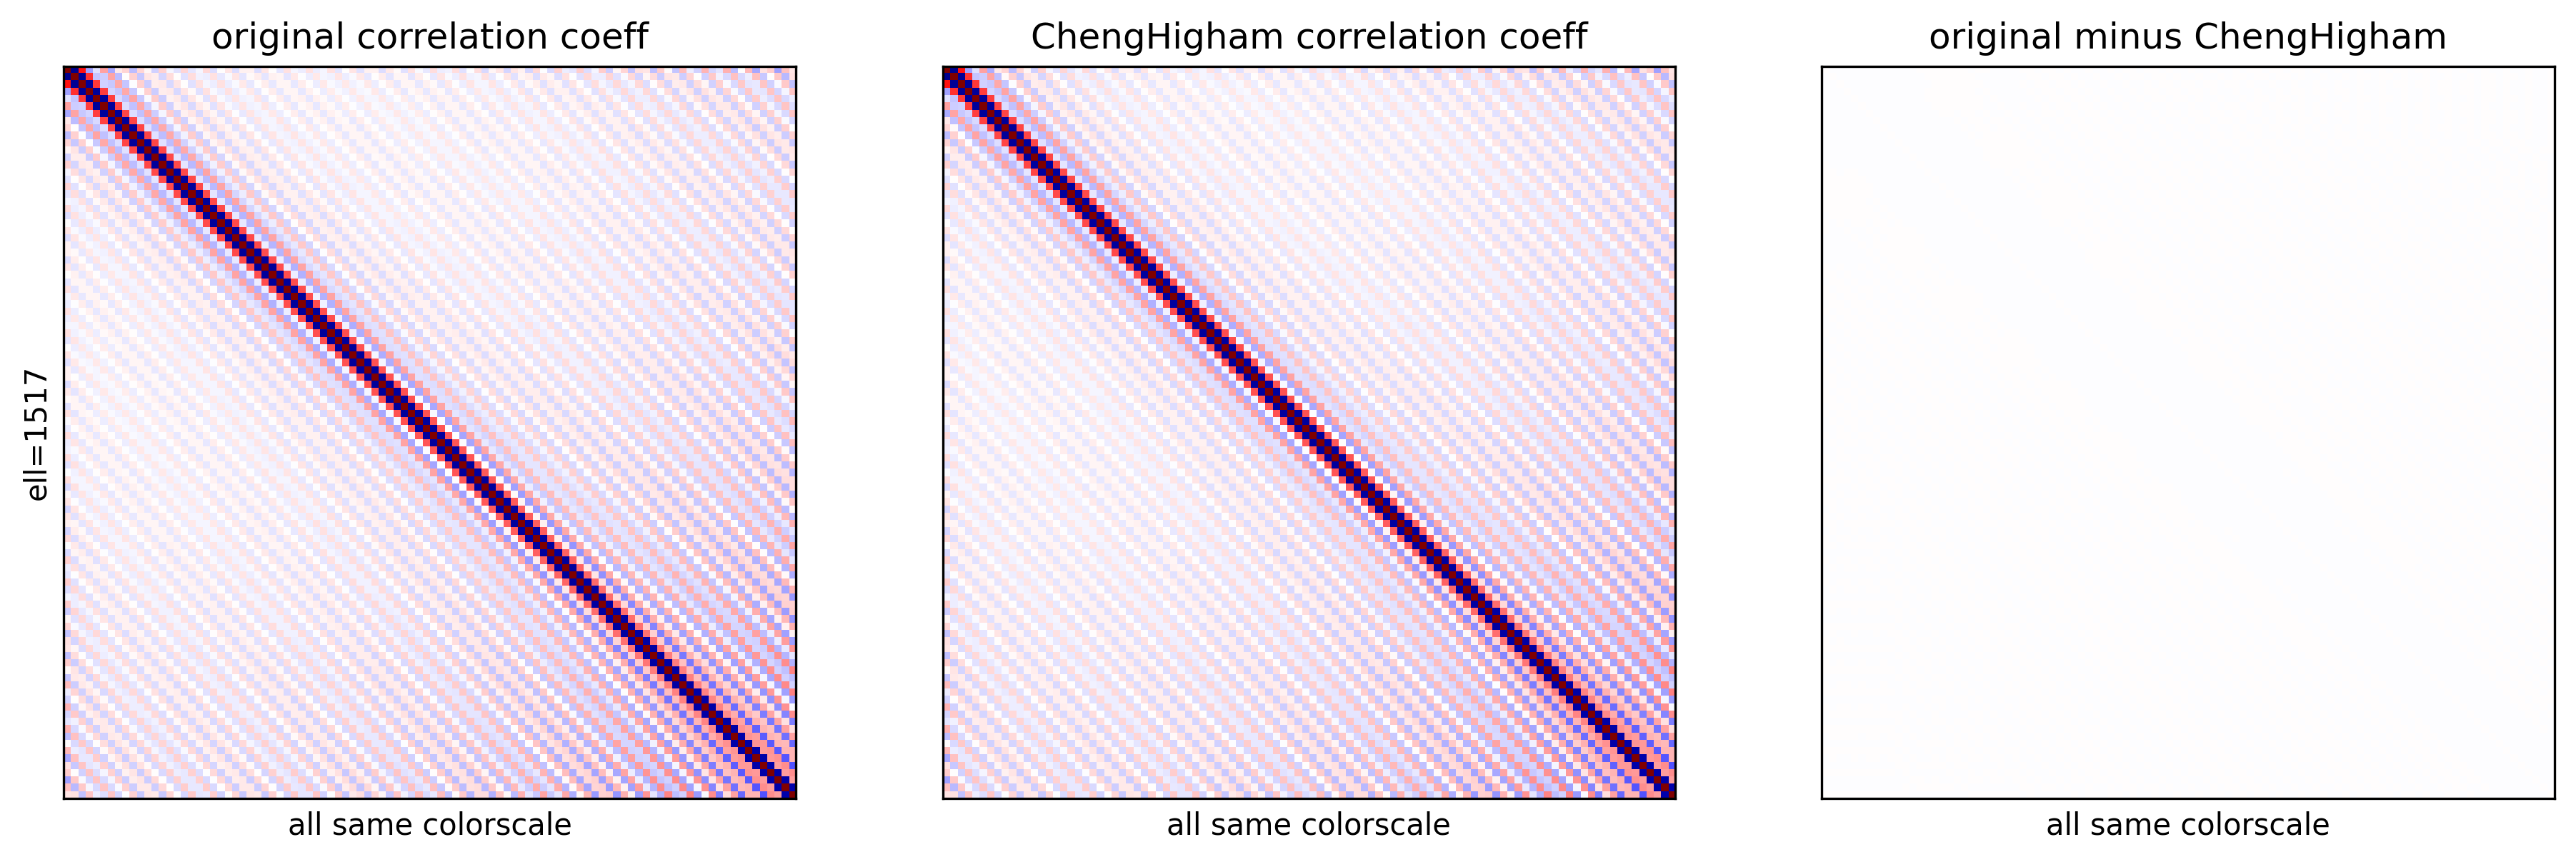

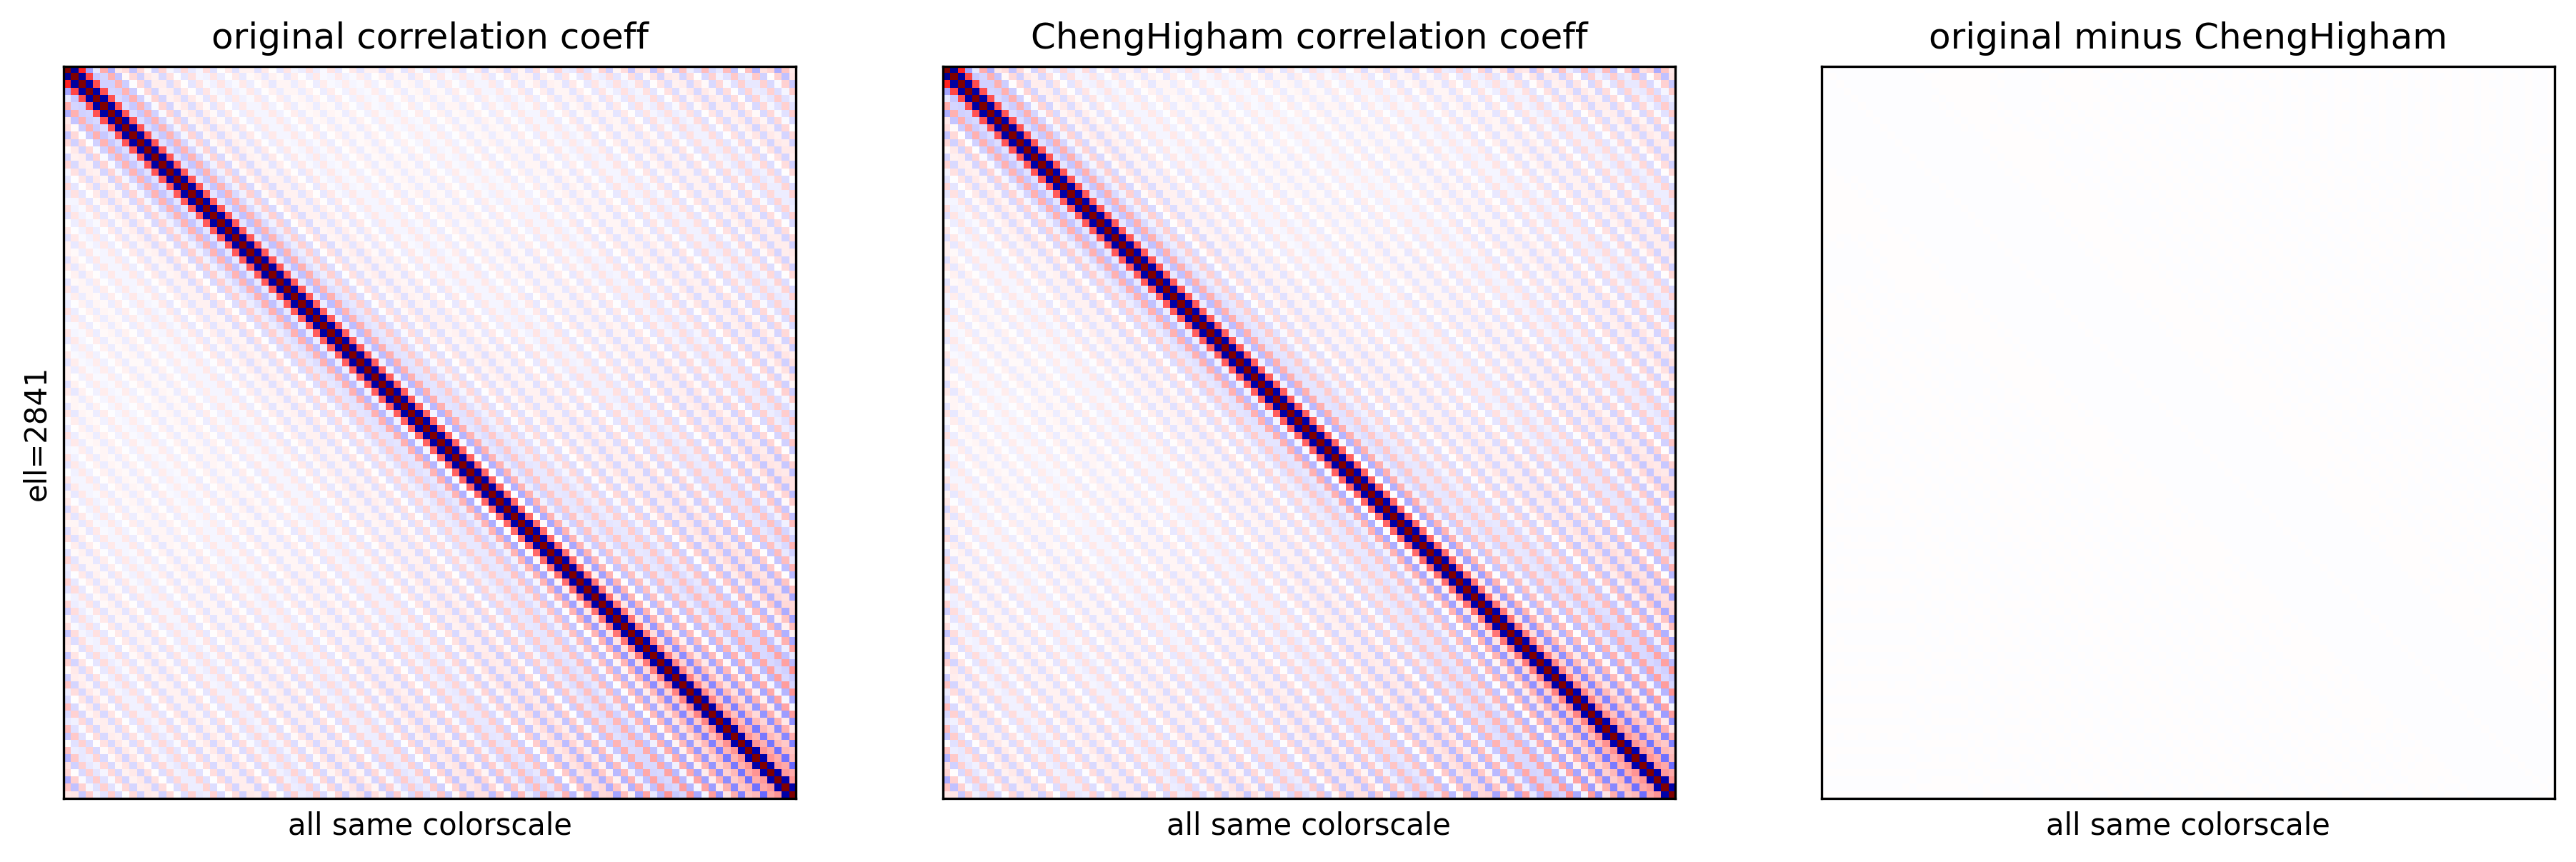

In [8]:
Lambda_idx = 24
Lambda = Lambdas[Lambda_idx]
#IHi_IHi############################################
IHiIHi = np.zeros((len(ells), n_bins, n_bins))

for idx1 in trange(n_bins):
    for idx2 in range(idx1, n_bins):
        IHiIHi_fname = '/scratch/users/delon/LIMxCMBL/I_auto/from_s3df/%s/comb_'%(experiment)
        IHiIHi_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_b_%d_%d_%d_jax_qmc.npy'%(line_str,
                                                                                        zmin, zmax, 
                                                                                        Lambda_idx, 
                                                                                        n_bins,idx1, idx2)

        IHiIHi[:, idx1, idx2] = np.load(IHiIHi_fname)
        IHiIHi[:, idx2, idx1] = IHiIHi[:, idx1, idx2]
        
        
def cov2corr(arr):
    _diag = np.diag(arr)
    _deno = np.einsum('i,j->ij',_diag, _diag)
    return arr/np.sqrt(_deno)

patched_IHiIHi = np.zeros_like(IHiIHi)
for ell_idx in range(0,len(ells), 10):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, dpi = 300, facecolor='w',
                       figsize=(15,5))
    
    
    vb = np.max(np.abs(cov2corr(IHiIHi[ell_idx])))
    axs[0].imshow(cov2corr(IHiIHi[ell_idx]),
                 vmin = -vb, vmax = vb,
                 cmap = 'seismic')
    
    #Cheng and Higham, 1998
    eigenvalues, eigenvectors = np.linalg.eig(IHiIHi[ell_idx])
    patched_eigenvalues = np.where(eigenvalues <0, 0.0, eigenvalues)
    patched_IHiIHi[ell_idx] = eigenvectors @ np.diag(patched_eigenvalues) @ eigenvectors.T
    
    
    axs[1].imshow(cov2corr(patched_IHiIHi[ell_idx]),
                 vmin = -vb, vmax = vb,
                 cmap = 'seismic')
    
    
    axs[2].imshow((cov2corr(IHiIHi[ell_idx])-cov2corr(patched_IHiIHi[ell_idx])),
                 vmin = -vb, vmax = vb,
                 cmap = 'seismic')

    axs[0].set_title('original correlation coeff')
    axs[1].set_title('ChengHigham correlation coeff')
    axs[2].set_title('original minus ChengHigham')
    
    axs[0].set_ylabel('ell=%d'%(ells[ell_idx]))
    
    for i in range(3):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel('all same colorscale')


# moral is that it seems like differences only for ell values that dont matter 

# below is old, was checking something that I think actually doesn't make sense to check

## check (IHi_kappa dot eigenvector_i)^2 eigenvalue_i^{-1} (relevant for cosmic variance limit)
basically if the zero'd out eigenvalues are super relevant for SNR calculation then its not correct to zero them out

edit: I think this is only a reasonable check to make if all the eigenvalues are already positive

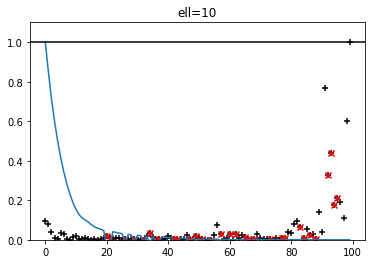

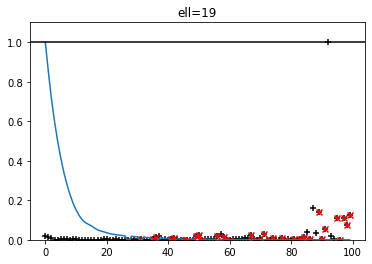

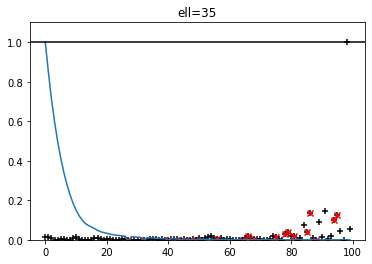

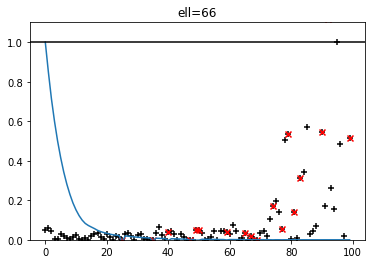

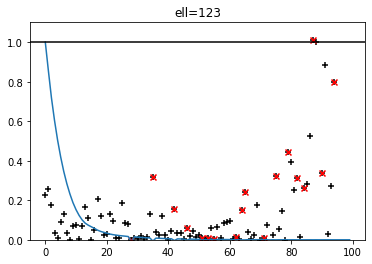

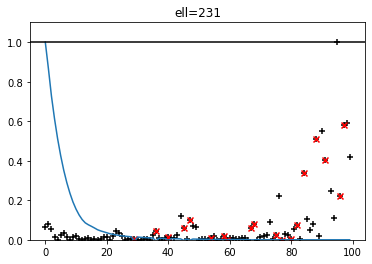

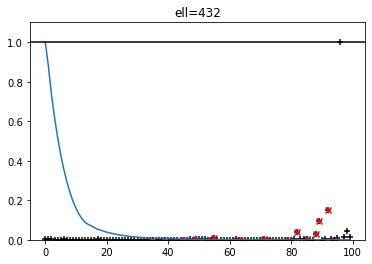

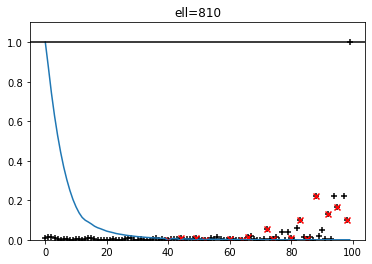

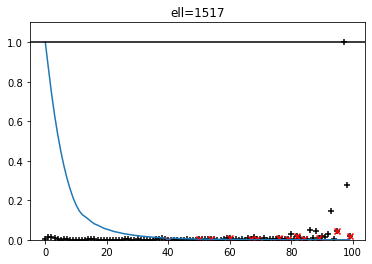

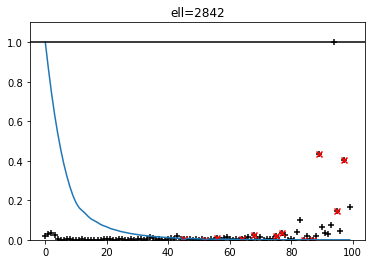

In [9]:
#IHi_kappa##########################################
ILo_kappa = np.zeros((100, n_bins))

for curr_bin in range(n_bins):
    oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_idx_%d_dblquad_n_bins_%d_curr_%d.npy'%(zmin, zmax, 
                                                                                                                        Lambda_idx, n_bins, 
                                                                                                                        curr_bin)
    ILo_kappa[:,curr_bin] = np.load(oup_fname)


IHi_kappa = I_kappa - ILo_kappa
#####################################################

for ell_idx in range(0,len(ells), 10):
    curr_IHiK = IHi_kappa[ell_idx]
    
    #Cheng and Higham, 1998
    eigenvalues, eigenvectors = np.linalg.eig(IHiIHi[ell_idx])
        
    _data = []
    for vi, li in zip(eigenvectors, eigenvalues):
        amp = np.dot(curr_IHiK, vi)
        _data += [amp**2 / (li)]
        
    _data = np.array(_data)
    
    zerod_idxs = np.where(eigenvalues < 0)
    unzerod_idxs = np.where(eigenvalues >= 0)
    char_scale = np.max(np.abs(_data[unzerod_idxs]))

    plt.scatter(np.arange(100), np.abs(_data)/char_scale, c='k', marker='+')
    plt.scatter(zerod_idxs[0], np.abs(_data[zerod_idxs])/char_scale, c='r', marker='x')
    plt.title('ell=%.0f'%(ells[ell_idx]))
    plt.plot(eigenvalues/np.max(eigenvalues))

    plt.ylim(0, 1.1)
    plt.axhline(1, c='k')
    plt.show()

moral is that what we're doing is not correct if we want to compute the cosmic variance limit of our SNR, but we weren't going to anyways for separate reasons and what's more relevant is when IHiIHi is regulated by both LIM noise and IHiK(x) IHiK(x')

In [11]:
from LIMxCMBL.experiments import *
_a, _b = CCAT_prime_Pei()
print(_a, _b)
Pei = np.array(_a) # kJy2 Mpc3 / sr2
print(Pei)

27394.542287784385 kJy2 Mpc3 / sr2 22232.451581120116 kJy2 Mpc3 / sr2
27394.542287784385


In [12]:
eComb_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_comb_'
eComb_fname +='zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, 
                                                                           zmax, 
                                                                           Lambda_idx, 
                                                                           n_bins)
eComb = np.load(eComb_fname)
eHIeHI_binned = eComb

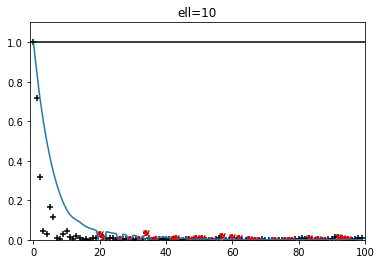

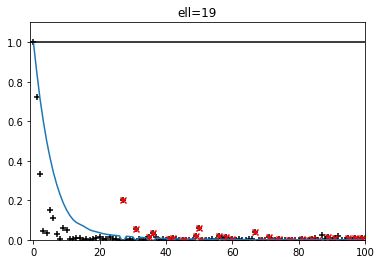

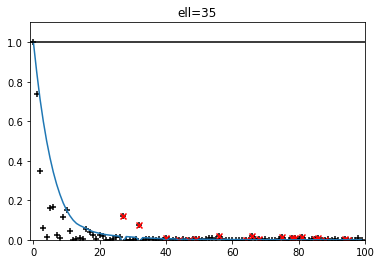

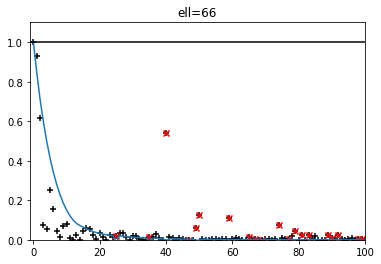

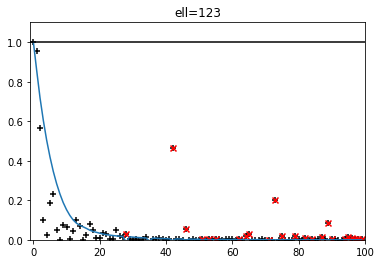

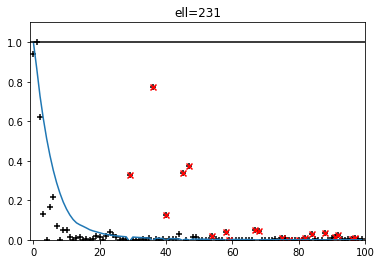

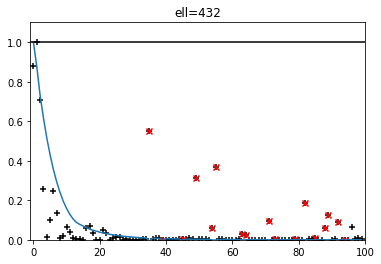

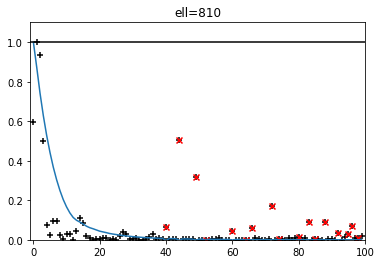

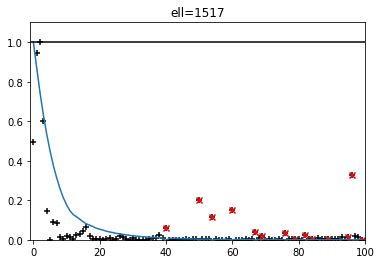

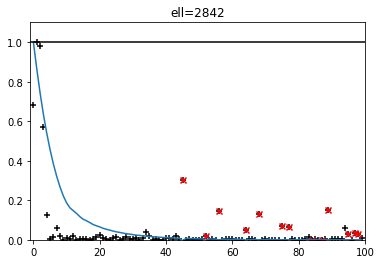

In [15]:
#IHi_kappa##########################################
ILo_kappa = np.zeros((100, n_bins))

for curr_bin in range(n_bins):
    oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_zmin_%.5f_zmax_%.5f_idx_%d_dblquad_n_bins_%d_curr_%d.npy'%(zmin, zmax, 
                                                                                                                        Lambda_idx, n_bins, 
                                                                                                                        curr_bin)
    ILo_kappa[:,curr_bin] = np.load(oup_fname)


IHi_kappa = I_kappa - ILo_kappa
#####################################################
    
for ell_idx in range(0,len(ells), 10):
    curr_IHiK = IHi_kappa[ell_idx]
    
    #Cheng and Higham, 1998
    eigenvalues, eigenvectors = np.linalg.eig(IHiIHi[ell_idx])

    #rotate noise to IHiIHi eigenbasis
    c_eHIeHI = Pei * eigenvectors.T @ eHIeHI_binned @ eigenvectors

    _data = []
    for vi, li, ei in zip(eigenvectors, eigenvalues, np.diag(c_eHIeHI)):
        amp = np.dot(curr_IHiK, vi)
        _data += [amp**2 / (li+ ei)]
        
    _data = np.array(_data)
    
    zerod_idxs = np.where(eigenvalues < 0)
    unzerod_idxs = np.where(eigenvalues >= 0)
    char_scale = np.max(np.abs(_data[unzerod_idxs]))

    

    plt.scatter(np.arange(100), np.abs(_data)/char_scale, c='k', marker='+')
    plt.scatter(zerod_idxs[0], np.abs(_data[zerod_idxs])/char_scale, c='r', marker='x')
    
    plt.plot(eigenvalues/np.max(eigenvalues))
    
    plt.title('ell=%.0f'%(ells[ell_idx]))
    
    plt.ylim(0, 1.1)
    plt.xlim(-1, 100)
    plt.axhline(1, c='k')
    plt.show()